## Import the image_embeddings lib

In [23]:
import image_embeddings
from pathlib import Path
import os
import cv2
import numpy as np

## Download an example dataset

For this notebook, I download a dataset from https://www.tensorflow.org/datasets/catalog/overview
but any image can be used.
For example :
* tf_flowers
* stanford_dogs
* cats_vs_dogs
* horses_or_humans
* imagewang

In [24]:
# Let's define some paths where to save images, tfrecords and embeddings

home = str(Path.home())
dataset = "tf_flowers"
pre_dataset= "imagenes_separadas_manquehue"
tipo_producto = "cremas"
producto = "3"
path_images_producto = f"{home}/{pre_dataset}/{tipo_producto}/{producto}/cortadas"
path_images_producto_test = f"{home}/{pre_dataset}/{tipo_producto}/{producto}/test"
path_images_test = f"{home}/{dataset}/images/test"
path_images = f"{home}/{dataset}/images/cortadas"
path_tfrecords = f"{home}/{dataset}/tfrecords/cortadas"
path_tfrecords_test = f"{home}/{dataset}/tfrecords/test"
path_embeddings = f"{home}/{dataset}/embeddings/cortadas"
path_embeddings_test = f"{home}/{dataset}/embeddings/test"

## Eliminar datos previos

In [25]:
import shutil 

for the_file in os.listdir(path_images_test):
    file_path = os.path.join(path_images_test, the_file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
    except Exception as e:
        print(e)

for the_file in os.listdir(path_images):
    file_path = os.path.join(path_images, the_file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
    except Exception as e:
        print(e)    
        
for the_file in os.listdir(path_tfrecords):
    file_path = os.path.join(path_tfrecords, the_file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
    except Exception as e:
        print(e)

for the_file in os.listdir(path_tfrecords_test):
    file_path = os.path.join(path_tfrecords_test, the_file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
    except Exception as e:
        print(e)

for the_file in os.listdir(path_embeddings):
    file_path = os.path.join(path_embeddings, the_file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
    except Exception as e:
        print(e)
        
for the_file in os.listdir(path_embeddings_test):
    file_path = os.path.join(path_embeddings_test, the_file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
    except Exception as e:
        print(e)


## Guardar imagenes cuadradas en dataset

In [26]:
def square_image(img):
    size = img.shape
    
    h = size[0]
    w = size[1]
    d = size[2]
    
    sobra = int((abs(w-h))/2)
    promedio = int((w+h)/2)
    
    if w > h:
        
        img_cuadrada = np.zeros((w, w, d))
        img_cuadrada[sobra:promedio,:, :] = img
      
    else:
        img_cuadrada = np.zeros((h, h, d))
        img_cuadrada[:,sobra:promedio, :] = img
        
    img_cuadrada = cv2.resize(img_cuadrada, (512,512), interpolation = cv2.INTER_AREA)
    
    return img_cuadrada


lista_imagenes_test = os.listdir(path_images_producto_test)
lista_imagenes_cortadas = os.listdir(path_images_producto)

for path_imagen_test in lista_imagenes_test:
    
    path_imagen_test_split = path_imagen_test.split("jpg")[0]
    
    img_test = cv2.imread(path_images_producto_test +"/"+ path_imagen_test)
    img_test = square_image(img_test)
    cv2.imwrite(path_images_test + "/" + path_imagen_test_split + "jpeg", img_test)

    
for path_imagen_cortada in lista_imagenes_cortadas:
    path_imagen_cortada_split = path_imagen_cortada.split("jpg")[0]
    img_cortada = cv2.imread(path_images_producto +"/"+ path_imagen_cortada)
    img_cortada = square_image(img_cortada)
    cv2.imwrite(path_images + "/" + path_imagen_cortada_split + "jpeg", img_cortada)

## Transform image to tf records

Tf record is an efficient format to store image, it's better to use than raw image file for inference

In [27]:
image_embeddings.inference.write_tfrecord(image_folder=path_images,
                                          output_folder=path_tfrecords,
                                          num_shards=1)

image_embeddings.inference.write_tfrecord(image_folder=path_images_test,
                                          output_folder=path_tfrecords_test,
                                          num_shards=1)

Shard 0 saved after 0s
Shard 0 saved after 0s


## Build embeddings

Here, efficientnet is used, but the code is particularly simple, and any other model could be used
The input is tfrecords and the output is embeddings

In [28]:
image_embeddings.inference.run_inference(tfrecords_folder=path_tfrecords,
                                         output_folder=path_embeddings,
                                         batch_size=1)

image_embeddings.inference.run_inference(tfrecords_folder=path_tfrecords_test,
                                         output_folder=path_embeddings_test,
                                         batch_size=1)

18/18 [==============================] - 3s 122ms/step

Shard 0 done after 3s
Shard 0 saved after 3s
1/1 [==============================] - 1s 1s/step

Shard 0 done after 1s
Shard 0 saved after 1s


## Read the embeddings and build an index with it

The knn index is built using https://github.com/facebookresearch/faiss which makes it possible
to search embeddings in log(N) with lot of options to reduce memory footprint

In [29]:
[id_to_name, name_to_id, embeddings] = image_embeddings.knn.read_embeddings(path_embeddings)
index = image_embeddings.knn.build_index(embeddings)

[id_to_name_test, name_to_id_test, embeddings_test] = image_embeddings.knn.read_embeddings(path_embeddings_test)
index_test = image_embeddings.knn.build_index(embeddings_test)

## Search in the index

Let's pick a random product by id, retrieve its embedding and search in the index

Then let's display the closest products

goicoechea_Diabettx-emulsion-hidratante_1


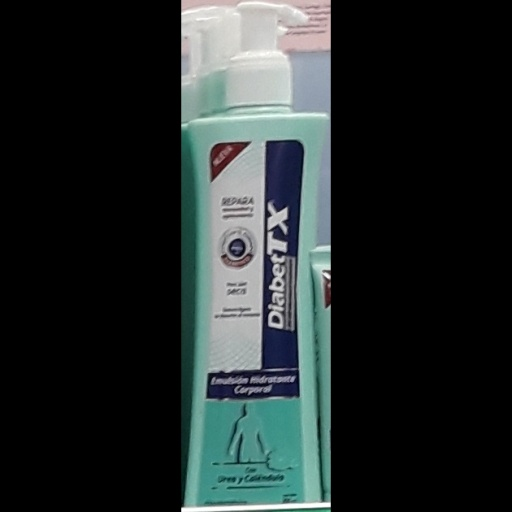

In [30]:
p=1
print(id_to_name[p])
image_embeddings.knn.display_picture(path_images, id_to_name[p])
results = image_embeddings.knn.search(index, id_to_name, embeddings[p])
image_embeddings.knn.display_results(path_images, results)

## Combination of images ?

Any vector in the same space can be used as query
For example I could have 2 image and want to find some example that are closeby to the 2, 
Let's just average them and see that happens !

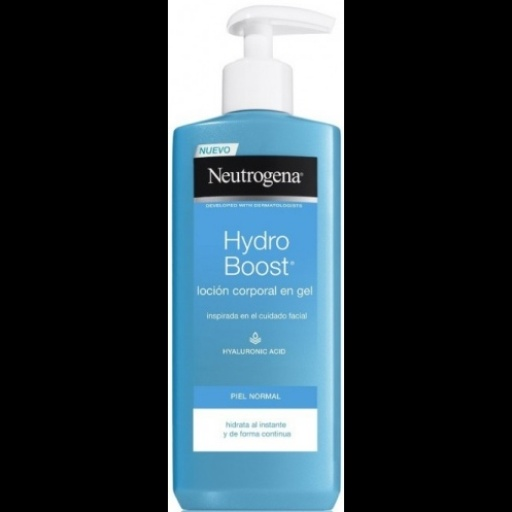

neutrogena_hydro-boost_1
simonds_dermo-cream-humectante_2
stives_humectacion-profunda-1000ml_1
lubriderm_rojo_1
neutrogena_confort_1
simonds_dermo-cream-humectante_1
simonds_dermo-cream-reafirmante_1
neutrogena_extra-care_1
goicoechea_Diabettx-alivia_1
lubriderm_rojo_2
lubriderm_reparacion-intensiva-familiar_1
goicoechea_Diabettx-emulsion-hidratante_1
stives_soothing_1
lubriderm_morado_2
nivea_bajo-la-ducha-piel-seca_1
nivea_mousse-nutritivo_1
spa-be_body-lotion-berries_1
spring-natural_rosado_1


In [32]:
image1 = id_to_name_test[0]
#image2 = id_to_name[p2]
image_embeddings.knn.display_picture(path_images_test, image1)
max_results=0

list_match = []

for i in id_to_name: 
    #image_embeddings.knn.display_picture(path_images, image2)
    results = image_embeddings.knn.search(index, id_to_name, (embeddings_test[0] + embeddings[i])/2, 7)
    if results[0][0]>max_results:
        max_results = results[0][0]
        max_name = id_to_name[i]
    
    dict_match_path = dict(Imagen_planograma = id_to_name[i], Match = results[0][0])
    list_match.append(dict_match_path)

list_match = sorted(list_match, key = lambda i: i["Match"],reverse=True)
ranking = [lista["Imagen_planograma"] for lista in list_match]

for pos in ranking:
    print(pos)

    #image_embeddings.knn.display_results(path_images, results)

We get mostly one of the picture. One thing that can be done to improve this is to
normalize the embeddings to get a better mix, let's try it !

In [ ]:
import numpy as np

def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)
normalized_embeddings = normalized(embeddings, 1)
index_normalized = image_embeddings.knn.build_index(normalized_embeddings)

In [ ]:
p1 = 1
p2 = 2
image1 = id_to_name[p1]
image2 = id_to_name[p2]
image_embeddings.knn.display_picture(path_images, image1)
image_embeddings.knn.display_picture(path_images, image2)
results = image_embeddings.knn.search(index_normalized, id_to_name, (normalized_embeddings[p1] + normalized_embeddings[p2])/2, 7)
image_embeddings.knn.display_results(path_images, results)

As expected we see a mixture of images that looks like both

## Exporting the embeddings to numpy
For easy access to the embeddings in other languages, we provide a function to export them to numpy

In [ ]:
from image_embeddings.knn import embeddings_to_numpy

In [ ]:
path_embeddings_numpy = f"{home}/{dataset}/embeddings_numpy"
embeddings_to_numpy(path_embeddings, path_embeddings_numpy)

## Next ?

What else can you build with this ?

An obvious example is retrieval (looking for closeby pictures) but recommendation systems or photo managers can also work very well using image embeddings !